<a href="https://colab.research.google.com/github/anthonymelson/portfolio/blob/master/MountainCar_Dominant2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#Set Style
plt.style.use('fivethirtyeight')

## Initialize Environment

In [2]:
env = gym.make("MountainCar-v0")
env.reset()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([-0.43147763,  0.        ])

### Set Hyper-Parameters

1. Learning Rate:  Determines how much weight to put on "new" information.
2. Discount: The percentage that future rewards should be valued at when compared to current rewards.  0.95 means that 95 now = 100 in the future.
3. Epsilon: Controls how random the agents behavior will be.  0.2 means the agent will act randomly 20% of the time.
4. Episodes: The number of times the agent will play the game.

Below, a seed is set for the environment and for other stochastic processes, both of which are needed for "reproducibility".

In [0]:
#rate of change of loss function
learning_rate = 0.2
#future value discount rate (greediness)
discount = 0.95
#amount of randomness
epsilon = 0.2
#number of episodes
episodes = 5000

env.seed(88)
np.random.seed(152)

### Exploration Policy/Schedule

Epsilon decay is a process where the epsilon value is lowered as the number of episodes increases.  Below, the epsilon value is set to be lowered linearily, and terminate after half the total episodes to be run have passed.  

However, the process begins at the 250th episode, until which time, the epsilon remains at its initial value (this is a step-wise addition to the linear policy, and works well on this problem because the reward system gives -1 every step of each episode and 0 if the goal is reached, meaning the changes are almost arbitrary until their is a win, which takes (on average) several hundred trials.

In [0]:
start_epsilon_decaying = 250
end_epsilon_decaying = episodes // 2
epsilon_decay_value = epsilon/(end_epsilon_decaying - start_epsilon_decaying)

### Discretization of State Space

In the MountainCar-v0 environment, the state space is Box(2), meaning their are two coninuous state variables (position and velocity).  Since the Q-Table cannot be infinitely large, these spaces must be discretized.

Below the position space is split into 8 bins, and the velocity space into 6 bins.  These should be considered hyperparameters and can have a large impact on the outcome of the learning process.

After that, a function is defined to "discretize" the new state spaces after each step of the game.

In [0]:
#discretize observation space (os)
discrete_state_size = [8, 6]
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/ discrete_state_size

def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size
    return tuple((discrete_state.astype(np.int)))

### Initialize Q-Table

The Q-Table is created as a uniform distribution between -2 and 0.  This is selected intuitively, as the rewards in the game are always -1 (except once per round at a maximum where it can be zero), meaning that the likely range for values will be between zero and one.

Furthermore, adding this variation help for the system to capitalize on new information early in the learning process, and ultimatly speeds up the backpropagation of values.  This is specifically important in MountainCar because the rewards are "delayed", making the backpropogation of values difficult.

In [6]:
q_table = np.random.uniform(low=-2, high=0, size=discrete_state_size + [env.action_space.n])
print(q_table.shape)

(8, 6, 3)


### The Q-Learning Algorithm and it's Implementation
Basic Design
1. Loop through the number of episodes
2. Reset the environment before every episode
3. Loop through the steps of each episode

In Each Episode
1. Decide on an action either by the current maximum Q-value for the current state, or at random at a rate equal to the current epsilon value
2. Take that action as a step, and unpack the new state, reward, and whether the episode is finished ("done")
3. Get the new discrete states
4. Update the Q-Table with the new information
5. Update the state with the new state
6. Decay the epsilon value (update it)

Throughout this process, many things can be counted.  Here, wins, regret, and the epsilon value is being tracked for later analysis.

In [0]:
epsilon_track = []
regret = []
win_count = []
wins = 0
for episode in range(episodes):
 
    regret_loc = []
    # Reset environment
    discrete_state = get_discrete_state(env.reset())
    done = False

    # Determine level of randomness
    while not done:
      
        #Decide on Action
        if np.random.random() > epsilon:
            action = np.argmax(q_table[discrete_state])
        else:
            action = np.random.randint(0, env.action_space.n)

        # Take Action
        new_state, reward, done, _ = env.step(action)

        # Get new discrete state space
        new_discrete_state = get_discrete_state(new_state)

        # Count rewards as negative
        regret_loc.append(-reward)


        # Get new maximum future value
        if not done:

            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action, )]
            
            
            # Q-learning function
            new_q = (1-learning_rate) * current_q + learning_rate * (reward + discount * max_future_q)
            q_table[discrete_state + (action, )] = new_q

        # If Game is Over    
        elif new_state[0] >= env.goal_position:
            q_table[discrete_state + (action,)] = 0
            wins = wins + 1       
        
        # Update the States
        discrete_state = new_discrete_state

    # Count By Episode    
    win_count.append(wins)
    regret.append(sum(regret_loc))
    epsilon_track.append(epsilon)
    env.close()

    #Control exploration
    if end_epsilon_decaying >= episode >= start_epsilon_decaying:
        epsilon -= epsilon_decay_value
        

### Plot Regret by Episode

Shows how much lost opportunity there was in each episode, and count total regret.  In this case, regret is being taken as any loss, despite the fact that the game cannot be solved in 0 moves.  This is desirable as their is not a known optimal policy to use as a benchmark, and this way of measuring the regret will work fine to compare this algorithm to another.

However, we could also compare this algorithm to a random action version to determine how "skilled" the model is (though it is not done here).

Takeaways:
1. After ~3,000 episodes, the agent had found a highly optimal policy, and could reach the goal every time it played (though that is not certain for all future trials, it did so almost two thousand times in a row).

2. Regret was very high for ~3,000 episodes, which could have been much shorter, leaving room for improvement.

Total Regret Over 5000 Episodes:  877633.0
Average Regret Per Episode: 175.5266


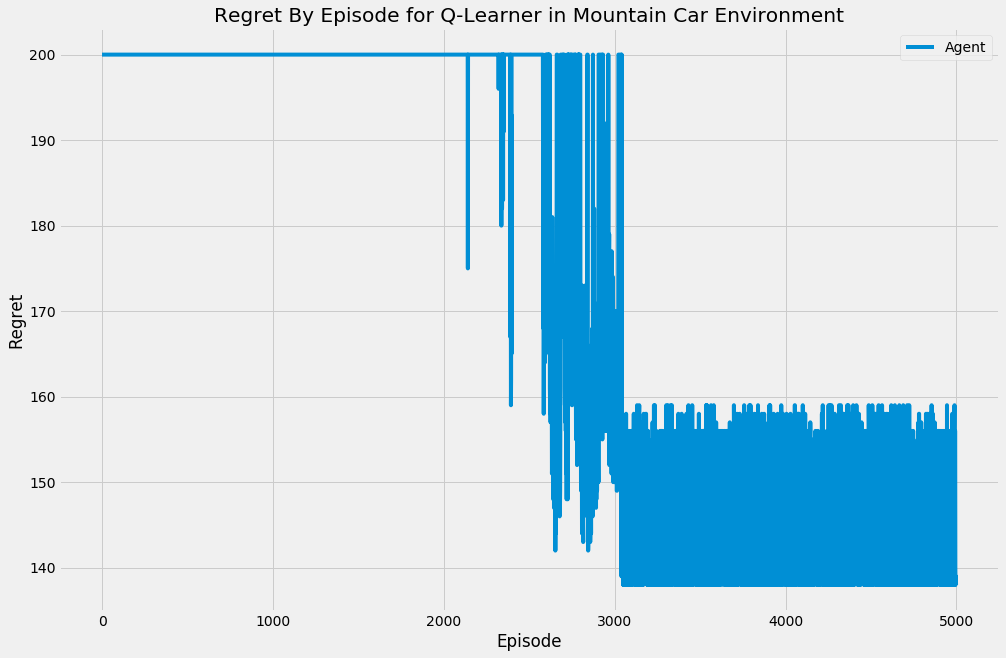

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.xlabel('Episode')
plt.ylabel('Regret')
plt.title("Regret By Episode for Q-Learner in Mountain Car Environment")
splot = pd.DataFrame(regret,list(range(0, len(regret))), ["Agent"])
#splot['Epsilon'] = epsilon_track
#splot["Learning Rate"] = lr_count
sns.lineplot(ax=ax, data = splot)
print("Total Regret Over 5000 Episodes: ", sum(regret))
print("Average Regret Per Episode:", sum(regret)/5000)

### Plot Wins vs Epsilon

The plot only shows the first 3000 episoded, as those after that were almost all wins, and this makes the relationship clearer.  The results are interesting because they show how well the agent performed as it explored less and exploited more.  It is clear that the agent was not performing as well when it was exploring more (which is to be expected).

In [20]:
scaled_wins = [win/1000 for win in win_count]
print(len(scaled_wins[0:3600]))
len(list(range(0, 3600)))

3600


3600

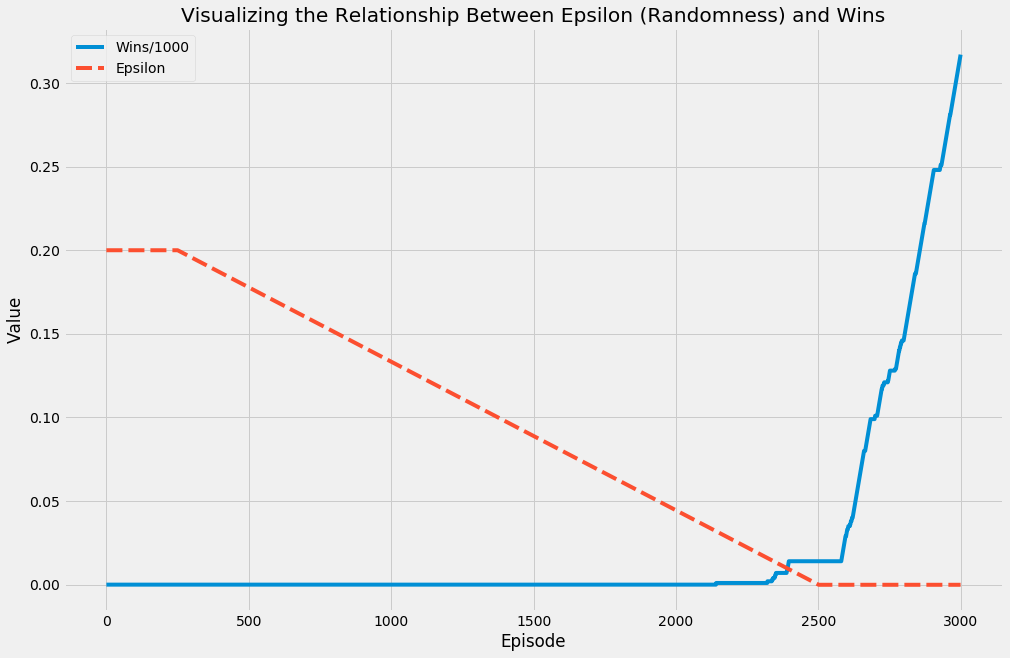

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title("Visualizing the Relationship Between Epsilon (Randomness) and Wins")
splot = pd.DataFrame(scaled_wins[0:3000],list(range(0, 3000)), ['Wins/1000'])
splot['Epsilon'] = epsilon_track[0:3000]
sns.lineplot(ax=ax, data = splot)